In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

##### Tracking error
1. Compute the center of mass (CoM) of the HD activity bump (i.e., the population vector estimate).
2. Compare it to the input direction (i.e., red dot).
3. The difference (in degrees, wrapped to [–180°, +180°]) is the tracking error.

In [2]:
# --- Parameters ---
num_cells = 180
timesteps = 100
gamma = 5           # Global inhibition strength
step_size = 5          # Degrees per step (random walk)
sigma = 40             # Input bump width
dt = 1.0               # Time step
tau = 50.0             # Time constant for exponential decay

In [3]:
# --- HD cells and preferred directions ---
preferred_directions = np.linspace(0, 360, num_cells, endpoint=False)
theta = np.deg2rad(preferred_directions)

In [4]:
# --- Circular Gaussian bump ---
def circular_gaussian(x, mu, sigma):
    delta = np.angle(np.exp(1j * np.deg2rad(x - mu)), deg=True)
    return np.exp(-0.5 * (delta / sigma) ** 2)

In [5]:
current_direction = 0
activity = circular_gaussian(preferred_directions, current_direction, sigma)

activity_over_time = [activity.copy()]
firing_rate_over_time = [np.maximum(0, np.tanh(activity.copy()))]
direction_over_time = [current_direction]
input_strength_over_time = []
inhibition_over_time = []
total_activity_over_time = []
tracking_error_over_time = []

In [6]:
# --- Simulation loop ---
for t in range(1, timesteps):
    # Random walk
    delta = np.random.uniform(-step_size, step_size)
    current_direction = (current_direction + delta) % 360
    direction_over_time.append(current_direction)

    # Input bump
    input_bump = circular_gaussian(preferred_directions, current_direction, sigma)
    input_strength = input_bump.sum()

    # Firing rate from current activity
    firing_rate = np.maximum(0, np.tanh(activity))
    
    # Inhibition from firing rates
    inhibition = gamma * np.mean(firing_rate)

    # Decay from raw activity
    decay = (dt / tau) * activity

    # Update activity
    activity = activity + input_bump - inhibition - decay
    activity = np.clip(activity, 0, None)

    # Firing rate for this timestep
    firing_rate = np.maximum(0, np.tanh(activity))

    # Compute bump center (population vector)
    cos_sum = np.sum(firing_rate * np.cos(np.deg2rad(preferred_directions)))
    sin_sum = np.sum(firing_rate * np.sin(np.deg2rad(preferred_directions)))
    bump_direction = (np.rad2deg(np.arctan2(sin_sum, cos_sum))) % 360

    # Circular error
    error = np.angle(np.exp(1j * np.deg2rad(bump_direction - current_direction)), deg=True)

    # Store
    activity_over_time.append(activity.copy())
    firing_rate_over_time.append(firing_rate.copy())
    input_strength_over_time.append(input_strength)
    inhibition_over_time.append(inhibition * num_cells)
    total_activity_over_time.append(firing_rate.sum())
    tracking_error_over_time.append(error)

activity_over_time = np.array(activity_over_time)
firing_rate_over_time = np.array(firing_rate_over_time)

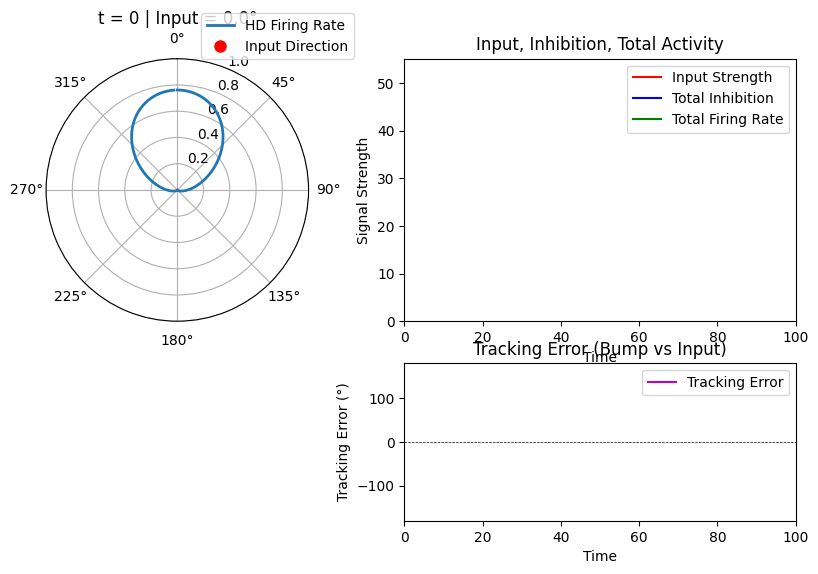

In [7]:
# --- Plotting setup ---
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.6], width_ratios=[1.2, 1.5])

# Polar plot
ax_polar = fig.add_subplot(gs[0, 0], polar=True)
ax_polar.set_theta_zero_location("N")
ax_polar.set_theta_direction(-1)
ax_polar.set_rlim(0, 1.0)
line, = ax_polar.plot([], [], lw=2, label='HD Firing Rate')
marker, = ax_polar.plot([], [], 'ro', markersize=8, label='Input Direction')
ax_polar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

# Diagnostic plot
ax_diag = fig.add_subplot(gs[0, 1])
ax_diag.set_xlim(0, timesteps)
ax_diag.set_ylim(0, max(input_strength_over_time + total_activity_over_time) * 1.1)
ax_diag.set_xlabel("Time")
ax_diag.set_ylabel("Signal Strength")
ax_diag.set_title("Input, Inhibition, Total Activity")
line_input, = ax_diag.plot([], [], 'r-', label='Input Strength')
line_inhib, = ax_diag.plot([], [], 'b-', label='Total Inhibition')
line_total, = ax_diag.plot([], [], 'g-', label='Total Firing Rate')
ax_diag.legend()

# Tracking error plot
ax_error = fig.add_subplot(gs[1, 1])
ax_error.set_xlim(0, timesteps)
ax_error.set_ylim(-180, 180)
ax_error.set_xlabel("Time")
ax_error.set_ylabel("Tracking Error (°)")
ax_error.set_title("Tracking Error (Bump vs Input)")
line_error, = ax_error.plot([], [], 'm-', label='Tracking Error')
ax_error.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax_error.legend()

# --- Animation update ---
def update(frame):
    rate = firing_rate_over_time[frame]
    line.set_data(theta, rate)
    input_angle = np.deg2rad(direction_over_time[frame])
    marker.set_data([input_angle], [1.05])
    ax_polar.set_title(f"t = {frame} | Input = {direction_over_time[frame]:.1f}°")

    x_vals = np.arange(1, frame+1)
    line_input.set_data(x_vals, input_strength_over_time[:frame])
    line_inhib.set_data(x_vals, inhibition_over_time[:frame])
    line_total.set_data(x_vals, total_activity_over_time[:frame])
    line_error.set_data(x_vals, tracking_error_over_time[:frame])
    return line, marker, line_input, line_inhib, line_total, line_error

ani = animation.FuncAnimation(
    fig, update,
    frames=timesteps,
    interval=100,
    blit=False,
    repeat=False
)

ani.save("plot_ani/rsc_hd_with_transfer_function.gif", writer='pillow', fps=20)